<a href="https://colab.research.google.com/github/saritmaitra/AL-VAR-VECM-/blob/main/AL_VECM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Error correction model
- vector error correction model (VECM) is a restricted VAR designed for use with nonstationary series that are known to be cointegrated
- cointegration relations built into the specification so that it restricts the long-run behavior of the endogenous variables to converge to their cointegrating relationships while allowing for short-run adjustment dynamics
-  cointegration term is known as the error correction term since the deviation from long-run equilibrium is corrected gradually through a series of partial short-run adjustments.
- Our series have nonzero means and deterministic trends as well as stochastic trends

In [2]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy, warnings
from pandas import DataFrame, merge, concat
import glob
plt.style.use('dark_background')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

  Created wheel for pyforest: filename=pyforest-1.0.3-py2.py3-none-any.whl size=13716 sha256=74aff952dc8ce171f01320eb14eab433d796fd379780cf4a3f6e81173dd65642
  Stored in directory: /root/.cache/pip/wheels/af/0b/39/340a7f15fc8d4ff5ab50847b28789afea04452a9d51b9721b5
Successfully built pyforest


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving AL_final_data.csv to AL_final_data.csv


In [4]:
df = pd.read_csv("AL_final_data.csv")
df.head()

<IPython.core.display.Javascript object>

,Unnamed: 0,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
0,0,2020-05-01 00:00:00,2877.125,1094465.0,1258140.0,1695.85,8846.125,107301000.0
1,1,2020-05-01 00:01:00,2875.375,1094215.0,1257935.0,1695.60,8841.250,107368000.0
2,2,2020-05-01 00:02:00,2874.625,1094165.0,1257765.0,1695.65,8837.750,107376500.0
3,3,2020-05-01 00:03:00,2874.125,1094115.0,1257565.0,1695.40,8836.750,107381500.0
4,4,2020-05-01 00:04:00,2875.250,1094190.0,1257535.0,1694.85,8841.125,107376500.0


In [5]:
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df.tail()

,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
29340,2020-05-29 20:56:00,3027.25,1111740.0,1235400.0,1731.50,9588.625,107675000.0
29341,2020-05-29 20:57:00,3027.25,1111750.0,1235450.0,1731.20,9588.500,107830000.0
29342,2020-05-29 20:58:00,3027.25,1111650.0,1235450.0,1731.45,9588.625,107830000.0
29343,2020-05-29 20:59:00,3027.25,1113400.0,1235450.0,1731.30,9587.375,107835000.0
29344,2020-05-29 21:00:00,3027.25,1113400.0,1237150.0,1731.35,9591.125,107835000.0


In [6]:
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   es      29345 non-null  float64
 1   eurusd  29345 non-null  float64
 2   gbpusd  29345 non-null  float64
 3   gc      29345 non-null  float64
 4   nq      29345 non-null  float64
 5   usdjpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

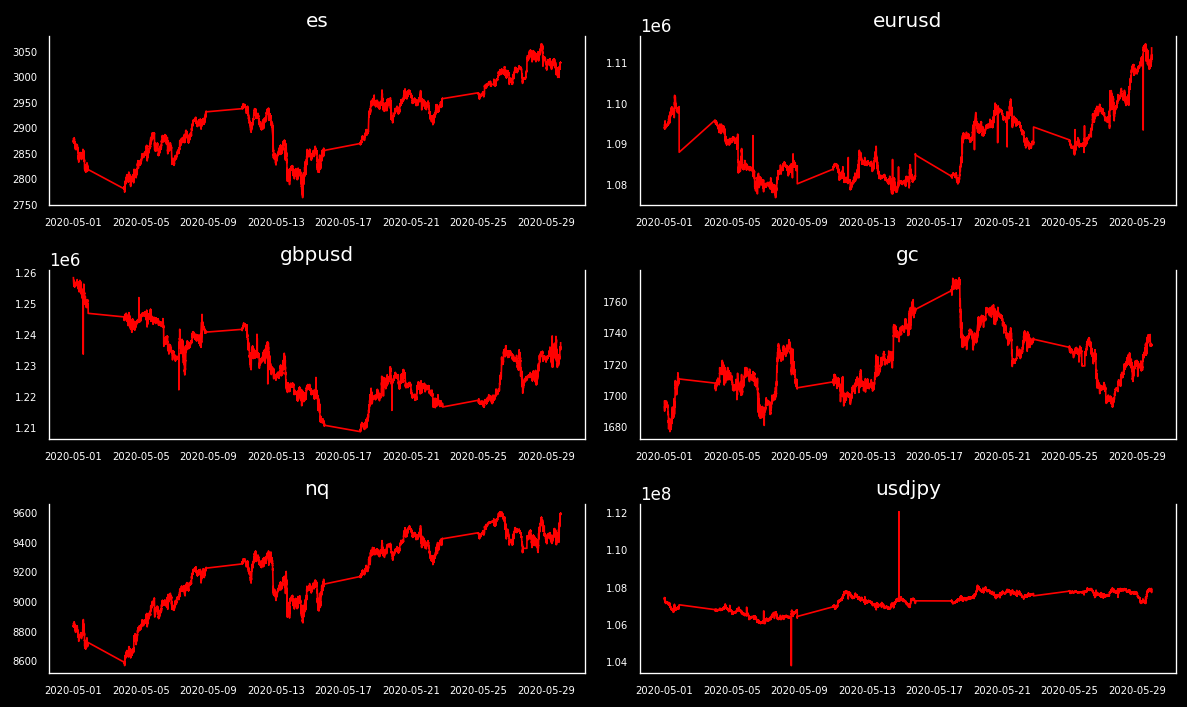

In [8]:
# Plot
plt.style.use('dark_background')
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    dataset = df[df.columns[i]]
    ax.plot(dataset, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

We have seen earler (VAR model) that all the series are unit root non-stationary, they may be co-integrated. This extension of unit root concept to multiple time series means that a liner combination of two or more series is stationary and hence, mean reverting. We also have seen that, VAR model is not equipped to handle this case without differencing. So, we will use here Vector Error Correction Model (VECM). We will explore here cointegratyion becase , if present and assumed to pressist, it can be leveraged for trading strategy.

However, the concept of an integrated multivariate series is complicated by the fact that, all the component series of the process may be individually integrated but the process is not jointly integrated in the sense that one or more linear combinations of the series exist that produce a new stationary series.

To simplify, a combination of two co-integrated series has a stable mean to which this linear combination reverts. A multivariate series with this characteristics is said to be cointegrated.

### Test for cointegartion
To verify further the relevance of the model, there is need to test for cointegration. In order to assume a long run relationship in the model despite the fact that the series are drifting apart or trending either upward or downward? having a long-run equilibrium.

Note: Cointegration test should be performed on the level form of the variables and not on their first difference. Both tests are performed as shown below.

There are two major approaches to test for cointegration:
- Engle-Granger twio step method
- Johansen procedure

Engle-Granger method involves regressing one series over another and then applying ADF unit root test to the regression residual. If H0 (null hypothesis) can be rejected, then we can assume that residuals are stationary and the series are cointegrated. A benefot of this approach is that, the regression cofficient represents  the multiplier that renders the combinationn stationary i.e. mean reverting.

Johansen procedure tests the restrictions imposed by cointegration on a VAR model. 

### Johansen co-integration on level data:
Johansen test assesses the validity of a cointegrating relationship, using a maximum likelihood estimates (MLE) approach.

Two types of Johansen’s test:

- one uses trace (from linear algebra),
- the other a maximum eigenvalue approach (an eigenvalue is a special scalar; when we multiply a matrix by a vector and get the same vector as an answer, along with a new scalar, the scalar is called an eigenvalue).
- Both forms of the test will determine if cointegration is present. The hypothesis is stated as:

Null hypothesis (H0) for both: no cointegrating equations.

The difference is in the alternate hypothesis (H1): the trace test alternate hypothesis is simply that the number of cointegrating relationships is at least one (shown by the number of linear combinations).

Rejecting the null hypothesis is basically stating there is only one combination of the non-stationary variables that gives a stationary process.

In [9]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import CointRankResults

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
pd.options.display.float_format = "{:.2f}".format

"""
definition of det_orderint:
-1 - no deterministic terms
0 - constant term
1 - linear trend
"""

print('Eigen statistic:')
print(coint_johansen(df, det_order = 1, k_ar_diff = 8).eig) # eigen statistic
print()
print('Critical values:')
print(coint_johansen(df, det_order = 1, k_ar_diff = 8).cvt) # critical values(90,95,99) for trace statistic
print()
print('Trace statistic:')
print(coint_johansen(df, det_order = 1, k_ar_diff = 8).lr1) #  trace statistic values.

<IPython.core.display.Javascript object>

Eigen statistic:
[0.00524096 0.00108868 0.00069746 0.00045406 0.00021149 0.00016734]

Critical values:
[[102.4674 107.3429 116.9829]
 [ 75.1027  79.3422  87.7748]
 [ 51.6492  55.2459  62.5202]
 [ 32.0645  35.0116  41.0815]
 [ 16.1619  18.3985  23.1485]
 [  2.7055   3.8415   6.6349]]

Trace statistic:
[231.01349093  76.86033757  44.90556245  24.43779121  11.11437692
   4.90935319]


Here, we see that trace statistics (76.86033757  44.90556245  24.43779121  11.11437692) are < critical values @95% (79.24, 55.24, 35.01, 18.39).

Interpreting Johansen Cointegration Test Results
- output releases two statistics, Trace Statistic and Max-Eigen Statistic
- Rejection criteria is at 0.05 level
- Reject (H0) null hypothesis if the p-value <= 0.05 means there is no cointegrating equations.

### Eigen and Trace statistic (Johansent co-integration)

In [11]:
pd.options.display.float_format = "{:.2f}".format
model = coint_johansen(endog = df, det_order = 0, k_ar_diff = 8)

print("\nnormalized eigenvector 0\n", model.evec[:,0] / model.evec[:,0][0])
print("\nnormalized eigenvector 1\n", model.evec[:,1] / model.evec[:,1][0])
print("\ntest statistics\n", model.lr1[0], model.lr1[1]) # Trace statistic
print("\ncritical values\n", model.cvt[0], model.cvt[1]) # Maximum eigenvalue statistic
print("\neig\n", model.eig)  # Eigenvalues of VECM coefficient matrix
print("\nevec\n", model.evec)  # Eigenvectors of VECM coefficient matrix
print("\nlr1\n", model.lr1)  # dim = (n,) Trace statistic
print("\nlr2\n", model.lr2) 
print("\ncvt\n", model.cvt) # Critical values (90%, 95%, 99%) of trace statistic
print("\ncvm\n", model.cvm) # Critical values (90%, 95%, 99%) of maximum eigenvalue statistic
print("\nind\n", model.ind) # Order of eigenvalues

<IPython.core.display.Javascript object>


normalized eigenvector 0
 [ 1.00000000e+00 -1.28099738e-02  8.52789191e-03  1.21507909e+00
 -5.47916544e-01  4.18535043e-04]

normalized eigenvector 1
 [ 1.00000000e+00 -5.77393675e-03  5.42036754e-03  3.02286576e+00
 -2.96545096e-02 -3.76238235e-06]

test statistics
 223.65261025071345 69.59540232505341

critical values
 [ 91.109   95.7542 104.9637] [65.8202 69.8189 77.8202]

eig
 [5.23770799e-03 1.06822476e-03 6.92215965e-04 3.95860840e-04
 1.89995071e-04 2.51508322e-05]

evec
 [[ 8.27454198e-03  1.93989277e-02  4.50876970e-02 -1.61530048e-03
   3.65505444e-02 -6.73818655e-03]
 [-1.05996666e-04 -1.12008181e-04 -9.24086151e-05 -2.18865531e-05
  -3.16979511e-05  1.36891964e-04]
 [ 7.05643996e-05  1.05149318e-04 -1.38118572e-04 -3.51522270e-05
  -9.23987742e-06 -2.75895990e-05]
 [ 1.00542230e-02  5.86403542e-02  9.21519414e-03 -4.56043506e-02
  -8.74999395e-03  8.71288218e-03]
 [-4.53375845e-03 -5.75265687e-04 -1.35882374e-02  4.12811125e-03
  -9.83616206e-03  6.80052062e-04]
 [ 3.4631

In [12]:
# simplifying the above test statotistic in tabular format as below
# trace test

out = coint_johansen(endog = df, det_order = 1, k_ar_diff = 8)
d = {'0.90':0, '0.95':1, '0.99':2}
traces = out.lr1
cvts = out.cvt[:, d['0.95']]
def adjust(val, length= 6): return str(val).ljust(length)
print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
for col, trace, cvt in zip(df.columns, traces, cvts):
    print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
es     ::  231.01    > 107.3429  =>   True
eurusd ::  76.86     > 79.3422   =>   False
gbpusd ::  44.91     > 55.2459   =>   False
gc     ::  24.44     > 35.0116   =>   False
nq     ::  11.11     > 18.3985   =>   False
usdjpy ::  4.91      > 3.8415    =>   True


We can see that in 4 equations, we can safely reject null hypotheses and alternate hypotheses of cointegration exists are accepted.

In [13]:
# eigen test

out = coint_johansen(endog = df, det_order = 1, k_ar_diff = 8)
d = {'0.90':0, '0.95':1, '0.99':2}
eigen = out.eig
cvts = out.cvt[:, d['0.95']]
def adjust(val, length= 6): return str(val).ljust(length)
print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
for col, eig, cvt in zip(df.columns, eigen, cvts):
    print(adjust(col), ':: ', adjust(round(eig,2), 9), ">", adjust(cvt, 8), ' =>  ' , eig > cvt)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
es     ::  0.01      > 107.3429  =>   False
eurusd ::  0.0       > 79.3422   =>   False
gbpusd ::  0.0       > 55.2459   =>   False
gc     ::  0.0       > 35.0116   =>   False
nq     ::  0.0       > 18.3985   =>   False
usdjpy ::  0.0       > 3.8415    =>   False


- Implies that the series in question are related and therefore can be combined in a linear fashion.
- That is, even if there are shocks in the short run, which may affect movement in the individual series, they would converge with time (in the long run).
- Estimate both long-run and short-run models.
- moving together in such a way that their linear combination results in a stationary time series
- sharing an underlying common stochastic trend.

Here we can safely use of vector autoregressive (VAR) model and vector error correction model (VECM) for analysis. Cointegration implies that time series will be connecting through an error correction model. The error correction model is important in time series analysis because it allows us to better understand long-run dynamics.

### Engle Granger cointegration test:

This uses the augmented Engle-Granger two-step cointegration test. Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.

The output returns

- t-statistic of unit-root test on residuals.
- asymptotic p-value based on MacKinnon (1994).
- critical values for the test statistic at the 1 %, 5 %, and 10 % levels 

The Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.

In [14]:
import statsmodels.tsa.stattools as ts 

print('EURUSD <-> GBPUSD')
print(ts.coint(df.eurusd, df.gbpusd))
print('_________________')
print('EURUSD <-> USDJPY')
print(ts.coint(df.eurusd, df.usdjpy))
print('_________________')
print('EURUSD <-> GC')
print(ts.coint(df.eurusd, df.gc))
print('_________________')
print('EURUSD <-> NQ')
print(ts.coint(df.eurusd, df.nq))
print('_________________')
print('EURUSD <-> ES')
print(ts.coint(df.eurusd, df.es))
print('_________________')

EURUSD <-> GBPUSD
(-0.0011403985320141323, 0.9858737322331345, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
EURUSD <-> USDJPY
(-1.592478383755012, 0.7240542800080573, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
EURUSD <-> GC
(-0.1471285472294473, 0.9818312116557235, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
EURUSD <-> NQ
(-1.0104216635073746, 0.9008527731835267, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
EURUSD <-> ES
(-1.4367130551772125, 0.7846522688206324, array([-3.89681326, -3.33633823, -3.04459454]))
_________________


p-value in all cases of 0.98/0.72/0.98/0.90/0.78 > 0.05 means that the null hypothesis (H0) of no cointegration cannot be rejected at the 5% level of significance. 

In [15]:
print('USDJPY <-> GBPUSD')
print(ts.coint(df.usdjpy, df.gbpusd))
print('_________________')
print('USDJPY <-> EURUSD')
print(ts.coint(df.usdjpy, df.eurusd))
print('_________________')
print('USDJPY <-> GC')
print(ts.coint(df.usdjpy, df.gc))
print('_________________')
print('USDJPY <-> NQ')
print(ts.coint(df.usdjpy, df.nq))
print('_________________')
print('USDJPY <-> ES')
print(ts.coint(df.usdjpy, df.es))
print('_________________')

USDJPY <-> GBPUSD
(-2.6585196013977876, 0.21485079967496595, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
USDJPY <-> EURUSD
(-2.7335777184797143, 0.18773511918415398, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
USDJPY <-> GC
(-2.470029631202599, 0.29244438848206494, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
USDJPY <-> NQ
(-3.676318004793329, 0.019649938803292896, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
USDJPY <-> ES
(-3.0436359095258063, 0.10019394372488444, array([-3.89681326, -3.33633823, -3.04459454]))
_________________


p-values in all 5 cases of 0.21/0.18/0.29/0.10 > 0.05 means that the null hypothesis (H0) of no cointegration cannot be rejected at the 5% level of significance. In one case (USDJPY <-> NQ, we find p (0.01) < 0.05 means that H1 is accepted means cointegrating relationships in these series.

In [16]:
print('GBPUSD <-> EURUSD')
print(ts.coint(df.gbpusd, df.eurusd))
print('_________________')
print('GBPUSD <-> USDJPY')
print(ts.coint(df.gbpusd, df.usdjpy))
print('_________________')
print('GBPUSD <-> GC')
print(ts.coint(df.gbpusd, df.gc))
print('_________________')
print('GBPUSD <-> NQ')
print(ts.coint(df.gbpusd, df.nq))
print('_________________')
print('GBPUSD <-> ES')
print(ts.coint(df.gbpusd, df.es))
print('_________________')

GBPUSD <-> EURUSD
(-2.661696713975026, 0.21365617053449582, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
GBPUSD <-> USDJPY
(-3.073544211863852, 0.09374098979559498, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
GBPUSD <-> GC
(-3.449728926420771, 0.03711966187770987, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
GBPUSD <-> NQ
(-2.5444315084440983, 0.2598327004441464, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
GBPUSD <-> ES
(-2.6170426599319487, 0.2300202284472262, array([-3.89681326, -3.33633823, -3.04459454]))
_________________


Here too, in one case (GBPUSD<-> GC, we find p-value (0.03) < 0.05, which means that H1 is accepted and cointegrating relationships in these series.

In [17]:
print('NQ <-> EURUSD')
print(ts.coint(df.nq, df.eurusd))
print('_________________')
print('NQ <-> USDJPY')
print(ts.coint(df.nq, df.usdjpy))
print('_________________')
print('NQ <-> GC')
print(ts.coint(df.nq, df.gc))
print('_________________')
print('NQ <-> GBPUSD')
print(ts.coint(df.nq, df.gbpusd))
print('_________________')
print('NQ <-> ES')
print(ts.coint(df.nq, df.es))
print('_________________')

NQ <-> EURUSD
(-2.0852499341930404, 0.4840793407906645, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
NQ <-> USDJPY
(-3.3968203452560477, 0.04270486157399038, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
NQ <-> GC
(-1.358088338509245, 0.811518066596715, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
NQ <-> GBPUSD
(-1.5402802879839912, 0.7454245263921138, array([-3.89681326, -3.33633823, -3.04459454]))
_________________
NQ <-> ES
(-2.387619494837818, 0.3307408952333254, array([-3.89681326, -3.33633823, -3.04459454]))
_________________


In [22]:
X = df[:15000] # subset of data

# spliting train/test
nobs = 120 # keeping 60 mins observations aside for validation
train_vecm, test_vecm = X[0:- nobs], X[- nobs:]

# Check size
print(train_vecm.shape); print(test_vecm.shape);
print('Description of training data:'); print(train_vecm.describe());

(14880, 6)
(120, 6)
Description of training data:
            es     eurusd     gbpusd       gc       nq       usdjpy
count 14880.00   14880.00   14880.00 14880.00 14880.00     14880.00
mean   2861.49 1084868.18 1235871.35  1711.53  9019.74 106839430.51
std      41.02    5361.84    9922.55    14.82   180.42    433673.74
min    2761.62 1076660.00 1215385.00  1676.50  8563.75 103750000.00
25%    2832.22 1080865.00 1228053.75  1703.25  8912.50 106509500.00
50%    2857.12 1083700.00 1236190.00  1708.90  9021.12 106838000.00
75%    2897.88 1086025.00 1243735.00  1721.05  9162.00 107158500.00
max    2946.38 1101775.00 1258140.00  1755.45  9337.50 112017500.00


### Cointegration rank of a VECM

In [19]:
# determining the number of cointegrating relationships using a VEC rank test.

rank1 = select_coint_rank(train_vecm, det_order = 1, k_ar_diff = 2,
                                   method = 'trace', signif=0.01)
print(rank1.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          253.2          117.0
  1   6          98.13          87.77
  2   6          48.46          62.52
-------------------------------------


- first column in the table shows the rank which is the number of cointegrating relationships for the dataset, while the second reports the number of equations in total. 
- λtrace statistics in the third column, together with the corresponding critical values. 
- first row of the table tests the null hypothesis of at most one cointegrating vector, against the alternative hypothesis that the number of cointegrating equations is strictly larger than the number assumed under the null hypothesis, i.e., larger than one. 
- test statistic of 253.2 considerably exceeds the critical value (117.0) and so the null of at most one cointegrating vector is rejected. 
- test statistic (98.13) also exceeds the critical value (87.77), so the null of at most two cointegrating vectors is rejected at the 1% level
- test statistic (48.46) do not exceeds the critical value (62.52), so the null of at most two cointegrating vectors cannot be rejected at the 1% level

Below test statistic on maximum eigen value:

Maximum-eigenvalue statistic assumes a given number of r cointegrating relations under the null hypothesis and tests this against the alternative that there are r + 1 cointegrating equations.

In [ ]:
rank2 = select_coint_rank(train_vecm, det_order = 1, k_ar_diff = 8, 
                              method = 'maxeig', signif=0.01)

print(rank2.summary())

# VECM model fitting

## Error correction model:

- shows the long-run equilibrium relationships of variables.
- includes a short-run dynamic adjustment mechanism that describes how variables adjust when they are out of equilibrium.
- uses adjustment coefficients to measure the forces that push the relationship towards long-run equilibrium.



In [23]:
# VECM model fitting

from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar.vecm import VECM

# pass "1min" frequency
train_vecm.index = pd.DatetimeIndex(train_vecm.index).to_period('1min')

# VECM
vecm = VECM(train_vecm, k_ar_diff=8, coint_rank = 4, deterministic='lo')

<IPython.core.display.Javascript object>

In [24]:
"""estimates the VECM on the prices with 8 lags, 2 cointegrating relationship, and 
a constant within the cointegration relationship"""

vecm_fit = vecm.fit()
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation es
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lin_trend   7.699e-06   1.14e-05      0.678      0.498   -1.46e-05       3e-05
L1.es          0.0238      0.019      1.238      0.216      -0.014       0.061
L1.eurusd      0.0001   4.56e-05      2.515      0.012    2.53e-05       0.000
L1.gbpusd  -2.528e-05   2.98e-05     -0.849      0.396   -8.36e-05    3.31e-05
L1.gc         -0.0082      0.019     -0.438      0.661      -0.045       0.028
L1.nq          0.0042      0.006      0.717      0.474      -0.007       0.016
L1.usdjpy  -7.002e-07   1.52e-07     -4.613      0.000   -9.98e-07   -4.03e-07
L2.es         -0.0379      0.019     -1.966      0.049      -0.076      -0.000
L2.eurusd      0.0006   4.82e-05     11.904      0.000       0.000       0.001
L2.gbpusd  -6.766e-05    3.2e-05     -2.113      

## Checking residual auto-correlation

In [25]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(vecm_fit.resid)

for col, val in zip(train_vecm.columns, out):
    print((col), ':', round(val, 2))

es : 2.0
eurusd : 2.0
gbpusd : 2.0
gc : 2.0
nq : 2.0
usdjpy : 2.0


In [26]:
eg = vecm_fit.test_granger_causality(caused="eurusd", causing="gbpusd")
eg.summary()

Test statistic,Critical value,p-value,df
3.931,1.880,0.000,"(9, 88854)"


In [27]:
je = vecm_fit.test_granger_causality(caused="usdjpy", causing="eurusd")
je.summary()

Test statistic,Critical value,p-value,df
0.2903,1.880,0.978,"(9, 88854)"


In [28]:
jnq = vecm_fit.test_granger_causality(caused="usdjpy", causing="nq")
jnq.summary()

Test statistic,Critical value,p-value,df
0.3445,1.880,0.960,"(9, 88854)"


In [29]:
jes = vecm_fit.test_granger_causality(caused="usdjpy", causing="es")
jes.summary()

Test statistic,Critical value,p-value,df
0.8222,1.880,0.596,"(9, 88854)"


In [30]:
pd.options.display.float_format = "{:.2f}".format
fcast, lower, upper = vecm_fit.predict(nobs, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(2))
print("\npoint forecasts:")
print(fcast.round(2))
print("\nupper bounds of confidence intervals:")
print(upper.round(2))

<IPython.core.display.Javascript object>

lower bounds of confidence intervals:
[[2.83418000e+03 1.08332712e+06 1.21543545e+06 1.74611000e+03
  9.00502000e+03 1.06948546e+08]
 [2.83260000e+03 1.08321682e+06 1.21526596e+06 1.74562000e+03
  8.99993000e+03 1.06913373e+08]
 [2.83177000e+03 1.08314145e+06 1.21513392e+06 1.74530000e+03
  8.99752000e+03 1.06880876e+08]
 [2.83115000e+03 1.08311064e+06 1.21508858e+06 1.74501000e+03
  8.99538000e+03 1.06858098e+08]
 [2.83040000e+03 1.08307304e+06 1.21496455e+06 1.74482000e+03
  8.99296000e+03 1.06835262e+08]
 [2.82986000e+03 1.08301965e+06 1.21487195e+06 1.74464000e+03
  8.99134000e+03 1.06816684e+08]
 [2.82937000e+03 1.08297907e+06 1.21480307e+06 1.74445000e+03
  8.98953000e+03 1.06800413e+08]
 [2.82885000e+03 1.08294166e+06 1.21473290e+06 1.74430000e+03
  8.98793000e+03 1.06783393e+08]
 [2.82839000e+03 1.08289847e+06 1.21467619e+06 1.74415000e+03
  8.98638000e+03 1.06768942e+08]
 [2.82794000e+03 1.08286002e+06 1.21461445e+06 1.74401000e+03
  8.98493000e+03 1.06755895e+08]
 [2.82751000

In [31]:
pd.options.display.float_format = "{:.2f}".format
fcast = DataFrame(fcast, index= test_vecm.index, columns= test_vecm.columns)
fcast.rename(columns = {'eurusd':'eurusd_pred', 'gbpusd':'gbpusd_pred', 'usdjpy':'usdjpy_pred',
                    'gc':'gc_pred', 'nq':'nq_pred', 'es':'es_pred'}, inplace = True)
fcast

<IPython.core.display.Javascript object>

,es_pred,eurusd_pred,gbpusd_pred,gc_pred,nq_pred,usdjpy_pred
timestamp,,,,,,
2020-05-15 13:58:00,2836.53,1083786.21,1216149.24,1747.17,9012.72,107075916.56
2020-05-15 13:59:00,2835.97,1083775.24,1216116.00,1747.10,9011.04,107082439.84
2020-05-15 14:00:00,2835.93,1083760.66,1216091.83,1747.08,9011.24,107082324.98
2020-05-15 14:01:00,2835.95,1083784.12,1216144.41,1747.05,9011.23,107087236.64
2020-05-15 14:02:00,2835.76,1083791.52,1216106.03,1747.09,9010.66,107088624.99
2020-05-15 14:03:00,2835.71,1083782.10,1216089.89,1747.10,9010.71,107091775.97
2020-05-15 14:04:00,2835.65,1083783.59,1216093.06,1747.10,9010.42,107094958.32
2020-05-15 14:05:00,2835.54,1083787.04,1216085.40,1747.11,9010.19,107095947.18
2020-05-15 14:06:00,2835.45,1083781.09,1216089.08,1747.11,9009.96,107098154.67


In [32]:
combine = concat([test_vecm, fcast], axis=1)
pred = combine[['eurusd', 'eurusd_pred', 'gbpusd', 'gbpusd_pred', 'usdjpy', 
                   'usdjpy_pred', 'gc', 'gc_pred', 'nq', 'nq_pred', 'es', 'es_pred']]
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color

pred.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_pred', 'gbpusd_pred', 'usdjpy_pred',
                                                               'gc_pred', 'nq_pred', 'es_pred']])

<IPython.core.display.Javascript object>

,eurusd,eurusd_pred,gbpusd,gbpusd_pred,usdjpy,usdjpy_pred,gc,gc_pred,nq,nq_pred,es,es_pred
timestamp,,,,,,,,,,,,
2020-05-15 13:58:00,1083890.000000,1083786.214448,1216010.000000,1216149.240213,107059500.000000,107075916.556605,1746.950000,1747.165648,9008.875000,9012.719703,2834.625000,2836.531428
2020-05-15 13:59:00,1083790.000000,1083775.243822,1215755.000000,1216115.999896,107087500.000000,107082439.843330,1747.600000,1747.101515,9015.125000,9011.044525,2834.500000,2835.973494
2020-05-15 14:00:00,1083460.000000,1083760.655162,1215150.000000,1216091.825448,107079000.000000,107082324.975142,1744.600000,1747.081324,9018.750000,9011.242112,2834.625000,2835.928744
2020-05-15 14:01:00,1083305.000000,1083784.117543,1214705.000000,1216144.405928,107086000.000000,107087236.641099,1743.750000,1747.049545,9017.250000,9011.226847,2834.875000,2835.948700
2020-05-15 14:02:00,1082990.000000,1083791.519734,1215045.000000,1216106.033569,107115000.000000,107088624.990219,1742.150000,1747.088171,9013.500000,9010.659194,2834.375000,2835.757582
2020-05-15 14:03:00,1082905.000000,1083782.100313,1215450.000000,1216089.889484,107137000.000000,107091775.969493,1742.050000,1747.104429,9014.000000,9010.714905,2834.125000,2835.706885
2020-05-15 14:04:00,1082755.000000,1083783.586068,1215605.000000,1216093.057883,107137000.000000,107094958.322349,1743.050000,1747.096134,9005.750000,9010.415071,2830.625000,2835.654412
2020-05-15 14:05:00,1082790.000000,1083787.040975,1215550.000000,1216085.398458,107155500.000000,107095947.178984,1743.750000,1747.108933,9002.125000,9010.194185,2831.125000,2835.535631
2020-05-15 14:06:00,1083065.000000,1083781.086516,1215600.000000,1216089.078666,107155000.000000,107098154.672570,1744.250000,1747.112624,9016.000000,9009.956163,2834.125000,2835.451422


## Evaluation metrics

In [34]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# score eur_usd
r_squared = r2_score(pred.eurusd, pred.eurusd_pred)
mae = mean_absolute_error(pred.eurusd, pred['eurusd_pred'])
mse = mean_squared_error(pred.eurusd, pred.eurusd_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred.eurusd, pred.eurusd_pred)
mape = np.mean(np.abs((pred['eurusd'].values - pred['eurusd_pred'].values) / pred['eurusd'].values)) * 100
sum_df = DataFrame(index = ['R-squared', 'Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean squared log Error', 'Mean absolute % error'])
sum_df['Accuracy metrics :    EURUSD'] = [r_squared, mae, mse, rmse, msle, mape]

# score gbp_usd
r_squared = r2_score(pred.gbpusd, pred.gbpusd_pred)
mae = mean_absolute_error(pred.gbpusd, pred['gbpusd_pred'])
mse = mean_squared_error(pred.gbpusd, pred.gbpusd_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred.gbpusd, pred.gbpusd_pred)
mape = np.mean(np.abs((pred['gbpusd'].values - pred['gbpusd_pred'].values) / pred['gbpusd'].values)) * 100
sum_df['GBPUSD'] = [r_squared, mae, mse, rmse, msle, mape]

# score usd_jpy
r_squared = r2_score(pred.usdjpy, pred.usdjpy_pred)
mae = mean_absolute_error(pred.usdjpy, pred['usdjpy_pred'])
mse = mean_squared_error(pred.usdjpy, pred.usdjpy_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred.usdjpy, pred.usdjpy_pred)
mape = np.mean(np.abs((pred['usdjpy'].values - pred['usdjpy_pred'].values) / pred['usdjpy'].values)) * 100
sum_df['USDJPY'] = [r_squared, mae, mse, rmse, msle, mape]

# score nq
r_squared = r2_score(pred.nq, pred.nq_pred)
mae = mean_absolute_error(pred.nq, pred['nq_pred'])
mse = mean_squared_error(pred.nq, pred.nq_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred.nq, pred.nq_pred)
mape = np.mean(np.abs((pred['nq'].values - pred['nq_pred'].values) / pred['nq'].values)) * 100
sum_df['NQ'] = [r_squared, mae, mse, rmse, msle, mape]

# score ES
r_squared = r2_score(pred.es, pred.es_pred)
mae = mean_absolute_error(pred.es, pred['es_pred'])
mse = mean_squared_error(pred.es, pred.es_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred.es, pred.es_pred)
mape = np.mean(np.abs((pred['es'].values - pred['es_pred'].values) / pred['es'].values)) * 100
sum_df['ES'] = [r_squared, mae, mse, rmse, msle, mape]

# score usd_jpy
r_squared = r2_score(pred.gc, pred.gc_pred)
mae = mean_absolute_error(pred.gc, pred['gc_pred'])
mse = mean_squared_error(pred.gc, pred.gc_pred)
rmse = np.sqrt(mse)
#mape = mean_absolute_percentage_error(pred_1.eur_usd - pred_1.eur_usd_pred)
msle = mean_squared_log_error(pred.gc, pred.gc_pred)
mape = np.mean(np.abs((pred['gc'].values - pred['gc_pred'].values) / pred['gc'].values)) * 100
sum_df['GC'] = [r_squared, mae, mse, rmse, msle, mape]
sum_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Accuracy metrics : EURUSD,GBPUSD,USDJPY,NQ,ES,GC
R-squared,-2.74,-2.46,-0.52,0.34,0.36,-0.67
Mean Absolute Error,1244.10,2502.65,71567.72,15.49,5.08,4.10
Mean squared error,2060591.94,7921443.95,6316381439.92,363.77,37.02,23.08
Root mean squared error,1435.48,2814.51,79475.67,19.07,6.08,4.80
Mean squared log Error,0.00,0.00,0.00,0.00,0.00,0.00
Mean absolute % error,0.11,0.21,0.07,0.17,0.18,0.23
